# Volume 3: Metropolis Algorithm
    Daniel Perkins
    MATH 405
    1/3/25

In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from math import sqrt
import seaborn as sns

## Problem 1

Write a function that uses the Metropolis Hastings algorithm to draw from the posterior distribution over the mean $\mu$ and variance $\sigma^2$. Use the given functions and Algorithm 1 to complete the problem.

Your function should return an array of draws, an array of the log probabilities, and an acceptance rate. 
Create plots resembling Figures 1 and 2:
 - Plot the log probabilities of the first 500 samples.
 - Plot the samples for $\mu$ in the order they were drawn, and likewise for $\sigma^2$.
 - Using `seaborn.kdeplot` plot the distribution of all samples for $\mu$, and likewise for $\sigma^2$.

Use $u=20$ for the parameter of the proposal function.
Use the initial state $\mathbf{y}_0=(\mu_0,\sigma^2_0)=(40,10)$.
Take 10,000 samples for both $\mu$ and $\sigma^2$. 

Compare your results with Figures 1 and 2.

In [2]:
def proposal(y, u):
    """Returns the proposal, i.e. a draw from Q(x,y) = N(x|y,uI)."""
    return stats.multivariate_normal.rvs(mean=y, cov=u*np.eye(len(y)))

In [3]:
def propLogDensity(x, muprior, sig2prior, scores):
    """Calculate the log of the proportional density funciton f."""
    if x[1] <= 0:
        return -np.inf
    logprob = muprior.logpdf(x[0]) + sig2prior.logpdf(x[1])
    logprob += stats.norm.logpdf(scores, loc=x[0], scale=np.sqrt(x[1])).sum()
    return logprob

In [4]:
def acceptance(x, y, muprior, sig2prior, scores):
    """
    Returns the acceptance probability of moving from y to x.
    """
    return np.exp(min(0, 
                  propLogDensity(x, muprior, sig2prior, scores) 
                - propLogDensity(y, muprior, sig2prior, scores)
    ))

In [17]:
def metropolis(y0, u, n_samples, muprior, sig2prior, scores):
    """
    Use the Metropolis algorithm to sample from posterior.
    Parameters:
        x0 ((2,) ndarray): The first entry is mu, the second entry is sigma^2.
        u (float): The standard deviation parameter for the proposal function.
        n_samples (int): The number of samples to generate.
        muprior, sig2prior (scipy.stats distributions): The prior distributions for mu and sigma^2.
        scores ((N,) ndarray): The array of exam scores
    
    Returns:
        draws ((n_samples, 2) ndarray): The MCMC samples.
        logprobs ((n_samples,) ndarray): The values of log f(y) of the samples.
        accept_rate (float): The proportion of accepted proposed samples.
    """
    # Initialize things
    draws = np.zeros((n_samples, 2))
    logprobs = np.zeros(n_samples)
    num_accepted = 0
    
    # Initial state
    y = y0
    logprobs[0] = propLogDensity(y, muprior, sig2prior, scores)
    draws[0] = y
    
    for t in range(1, n_samples):
        
        x = proposal(y, u)  # Propose state (Draw x from Q)
        a = np.random.rand()   # Draw a from unif(0, 1)
        acc_prob = acceptance(x, y, muprior, sig2prior, scores) # Compute acceptance probability
        
        if a < acc_prob: # Lines 6-9 of algorithm
            y = x  
            num_accepted += 1
            
        logprobs[t] = propLogDensity(y, muprior, sig2prior, scores)
        draws[t] = y   # Store the draw
        
    return draws, logprobs, num_accepted/n_samples

In [42]:
# Load in the data and initialize priors
scores = np.load("examscores.npy")

# Prior sigma^2 ~ IG(alpha, beta)
alpha = 3
beta = 50
sig2prior = stats.invgamma(alpha, scale=beta)

# Prior mu ~ N(m, s)
m = 80
s = 4
muprior = stats.norm(loc=m, scale=sqrt(s**2))

y0 = np.array([40, 10])
u = 20
n_samples = 10_000

draws, logprobs, accept_rate = metropolis(y0, u, n_samples, muprior, sig2prior, scores)

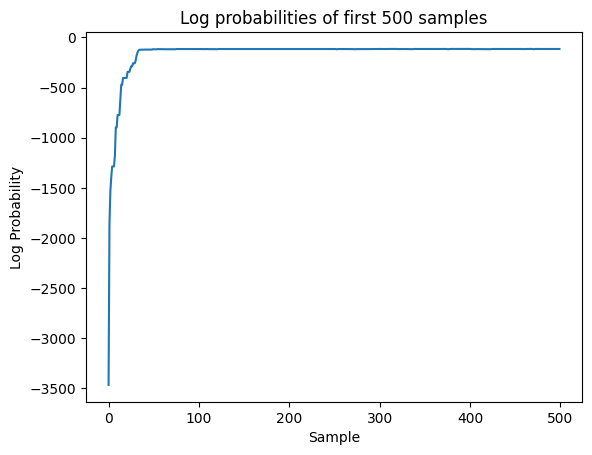

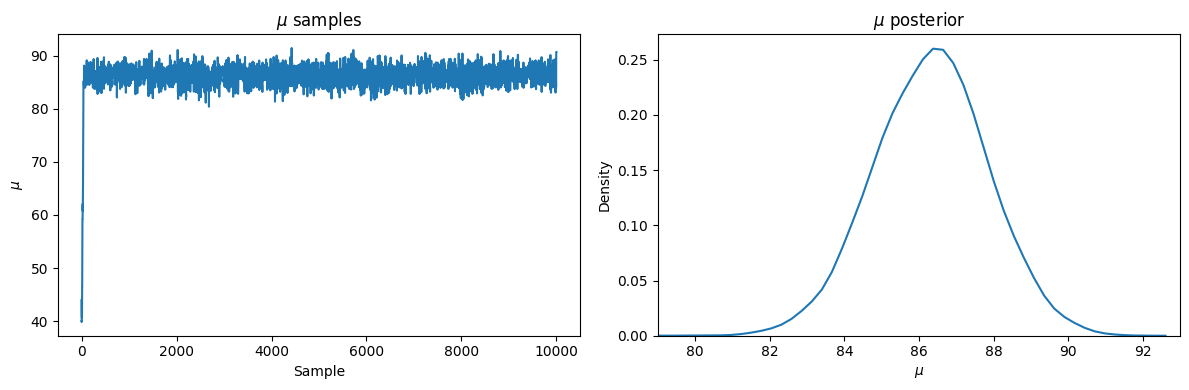

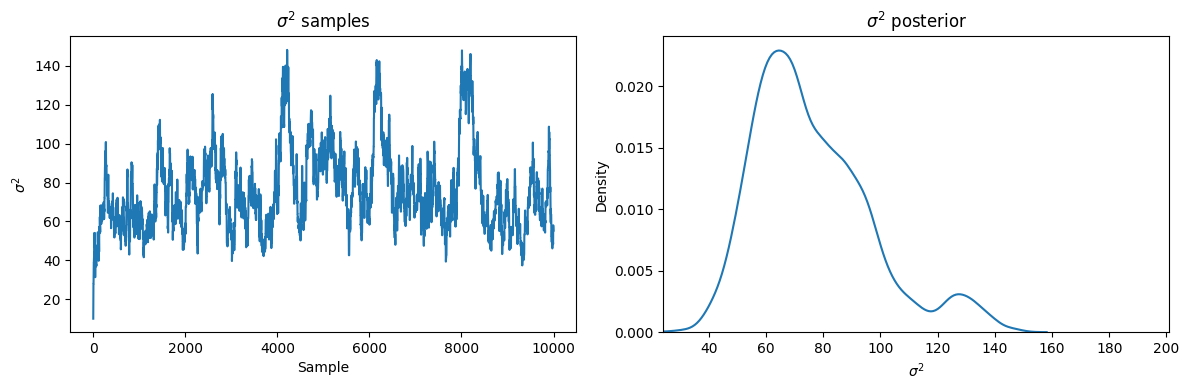

In [43]:
# Plot the log probability
plt.title("Log probabilities of first 500 samples")
plt.xlabel("Sample")
plt.ylabel("Log Probability")
plt.plot(np.arange(500), logprobs[:500])
plt.show()

# Plot samples and posterior for mu
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title(r"$\mu$ samples")
plt.plot(draws[:,0])
plt.xlabel("Sample")
plt.ylabel(r"$\mu$")

plt.subplot(122)
sns.kdeplot(draws[:, 0])
plt.xlim(79, 93)
plt.title(r"$\mu$ posterior")
plt.xlabel(r"$\mu$")
plt.ylabel("Density")

plt.tight_layout()
plt.show()


# Plot samples and posterior for sigma 2
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title(r"$\sigma^2$ samples")
plt.plot(draws[:,1])
plt.xlabel("Sample")
plt.ylabel(r"$\sigma^2$")

plt.subplot(122)
sns.kdeplot(draws[:, 1])
plt.xlim(24, 201)
plt.title(r"$\sigma^2$ posterior")
plt.xlabel(r"$\sigma^2$")
plt.ylabel("Density")

plt.tight_layout()
plt.show()


## Problem 2

Write a function that accepts a spin configuration $\sigma$ for a lattice as a NumPy array.
Compute the energy $H(\sigma)$ of the spin configuration.
Be careful to not double count site pair interactions!

In [44]:
def random_lattice(n):
    """Construct a random spin configuration for an nxn lattice."""
    random_spin = np.zeros((n, n))
    for k in range(n):
        random_spin[k, :] = 2*np.random.binomial(1, .5, n) - 1
    return random_spin

In [121]:
def lattice_energy(L):
    """Compute the energy of the spin configuration L.

    Parameter:
    L (ndarray): A spin configuration for a lattice.
    
    Returns:
    (float): The energy of the spin configuration.
    """
    # Initial conditions
    n = L.shape[0]
    # Add all the neighbors
    neighbors = np.roll(L, 1, axis=1) + np.roll(L, 1, axis=0)
    neighbors += np.roll(L, -1, axis=1) + np.roll(L, -1, axis=0)
    # Sum up the products
    E = -0.5*np.sum(L * neighbors)  # Divide by 2 (since things are double counted)
    return E

In [147]:
L = random_lattice(100)
L_energy = lattice_energy(L)
print(L_energy)

-244.0


## Problem 3

Write a function that accepts an integer $n$ and chooses a pair of indices $(i,j)$ where $0 \le i,j \le n-1$.
Each possible pair should have an equal probability $\frac{1}{n^2}$ of being chosen.

In [146]:
def flip_location(n):
    """Choose a random pair of indices 0 <= i,j <= n-1.
    Parameter:
    n (int): 1/(n^2) probability for each location
    
    Returns:
    (index1, index2) (tuple): the tuple pair of the chosen indices. 
    """
    # Draw from uniform integer distribution
    return tuple(np.random.randint(0, high=n, size=2))

print(flip_location(100))

(69, 33)


## Problem 4

Write a function that accepts a spin configuration $\sigma$, its energy $H(\sigma)$, and integer indices $i$ and $j$.
Compute the energy of the new spin configuration $\sigma^*$, which is $\sigma$ but with the spin flipped at the $(i,j)$ th entry of the corresponding lattice.
Do not explicitly construct the new lattice for $\sigma^*$.

In [263]:
def updated_energy(L, L_energy, i, j):
    """Compute the energy of the spin configuration that results
    when the (i,j)th spin of L is flipped.
    
    Parameters:
    L (ndarray): the spin configuration 
    L_energy (float): the energy of the spin configuration.
    i (int): the first index.
    j (int): the second index.
    Returns:
    (float): the energy of the new updated lattice
    """
    n = L.shape[0]
    # Find sum of all the neighbors
    right = L[(i+1)%n, j] + L[i, (j+1)%n] + L[i-1, j] + L[i, j-1]
    right = 2*L[i, j]*right
    return L_energy + right   # Equation 18.2

In [266]:
# Check to see if the function works
L = random_lattice(100)
L_energy = lattice_energy(L)
i, j = flip_location(100)
print("New function:", updated_energy(L, L_energy, i, j))

L_copy = L.copy()
L_copy[i, j] = L_copy[i, j] * -1
print("Correct Answer:", lattice_energy(L_copy))

New function: -44.0
Correct Answer: -44.0


## Problem 5

Write a function that accepts a float $\beta$ and spin configuration energies $H(\sigma)$ and $H(\sigma^*)$.
Calculate whether or not the new spin configuration $\sigma^*$ should be accepted (return `True` or `False`).

(Hint: np.random.binomial() might be useful function)

In [425]:
def accept(beta, energy_old, energy_new):
    """Accept or reject the new spin configuration.
    
    Parameters:
    beta (float): a quantity inversly proportional to the temperature.
    energy_old (float): the energy of the old lattice.
    energy_new (float): the energy of the updated lattice.
    
    Returns:
    (boolean): whether the new energy should be accepted or not
    """
    # Calculate A (equation 18.1)
    if energy_new < energy_old: log_A = 0  # Log space
    else: log_A = beta*(energy_old - energy_new)  # Log space
    return np.log(np.random.rand()) < log_A  # Accept new config with certain probability

In [426]:
# Verify that the function works
L = random_lattice(100)
L_energy = lattice_energy(L)
i, j = flip_location(100)
L_new_energy = updated_energy(L, L_energy, i, j)
beta = 0.1
print(accept(beta, L_energy, L_new_energy))

True


## Problem 6

Write a function that accepts a float $\beta>0$ and integers $n$, `n_samples`, and `burn_in`.
Initialize an $n\times n$ lattice for a spin configuration $\sigma$ using `random_lattice()`.
Use the Metropolis algorithm to (potentially) update the lattice `burn_in` times.
1. Use `flip_location()` to choose a site for possibly flipping the spin, thus defining a potential new configuration $\sigma^*$.
2. Use `updated_energy()` to calculate the energy $H(\sigma^*)$ of the proposed configuration.
3. Use `accept()` to accept or reject the proposed configuration. If it is accepted, set $\sigma = \sigma^*$ by flipping the spin at the indicated site.
4. Track $-\beta H(\sigma)$ at each iteration (independent of acceptance).

After the burn-in period, continue the iteration `n_samples` times, also recording every $100$th sample (to prevent memory failure).
Return the samples, the sequence of weighted energies $-\beta H(\sigma)$, and the acceptance rate.

Test your sampler on a $100 \times 100$ grid with $200000$ total iterations, with `n_samples` large enough so that you will keep $50$ samples, for $\beta = 0.2, 0.4, 1$.
Plot the proportional log probabilities, as well as a late sample from each test.


In [434]:
def ising_metropolis(beta, n=100, n_samples=5000, burn_in=195000):
    """Use the Metropolis algorithm to choose new spin configurations.

    Parameters:
        beta (float > 0): Constant inversely proportional to the temperature.
        N (int > 0): The size of the lattice.
        n_samples (int): The number of samples to generate.
        burnin (int): The number of iterations to burn before sampling.

    Returns:
        ((n_samples//100, n,n) ndarray): The sampled spin configurations.
        (n_samples + burn_in) ndarray: The weighted energies of each configuration.
        (float): The proportion of proposed samples that were accepted.
    """    
    # Initialize things
    draws = np.zeros((n_samples//100, n, n))
    weighted_energies = np.zeros(n_samples + burn_in)
    
    # Initial state
    L = random_lattice(n)  # Initialize nxn lattice
    L_energy = lattice_energy(L)
    weighted_energies[0] = -beta*L_energy
    
    # Burn in period
    for t in range(1, burn_in):
        i, j = flip_location(n)
        L_new_energy = updated_energy(L, L_energy, i, j)
        if accept(beta, L_energy, L_new_energy):  # See if the flip is accepted
            L[i, j] = L[i, j] * -1
            L_energy = L_new_energy
        weighted_energies[t] = -beta*L_new_energy
    
    # After burn in
    num_accepted = 0  
    for t in range(burn_in, burn_in+n_samples):
        i, j = flip_location(n)
        L_new_energy = updated_energy(L, L_energy, i, j)
        if accept(beta, L_energy, L_new_energy):  # See if the flip is accepted
            L[i, j] = L[i, j] * -1
            L_energy = L_new_energy
            num_accepted += 1
        weighted_energies[t] = -beta*L_new_energy
        if (t - burn_in) % 100 == 0:   # Update sample
            draws[(t - burn_in) // 100] = L
        
    return draws, weighted_energies, num_accepted/n_samples

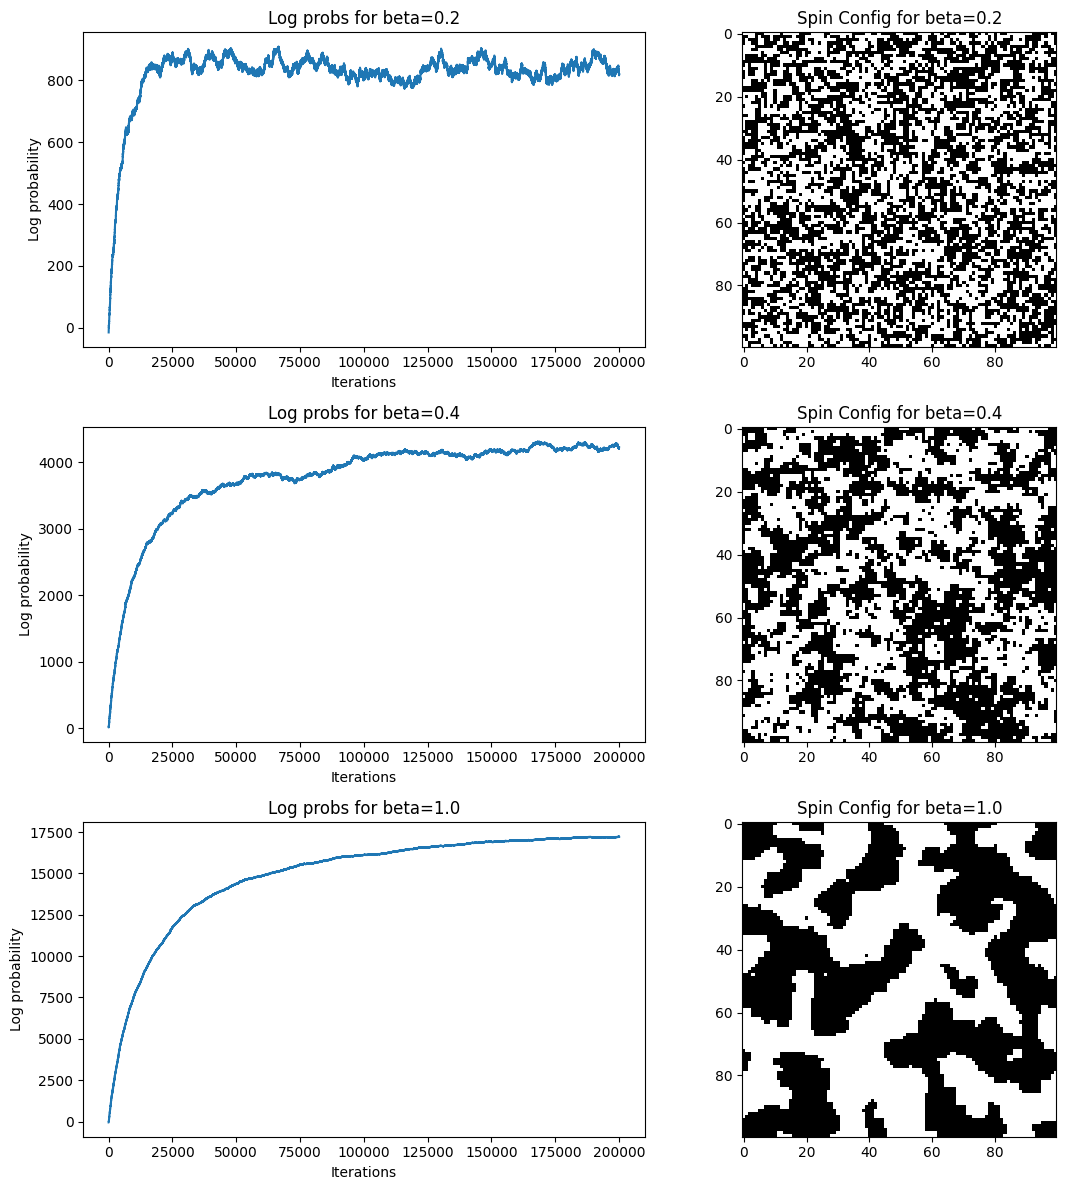

In [448]:
plt.figure(figsize=(12, 12))

betas = [0.2, 0.4, 1.]
for count, beta in enumerate(betas):
    # Call the metropolis algorithm
    draws, weighted_energies, accept_rate = ising_metropolis(beta, n=100, n_samples=5000, burn_in=195000)
    plt.subplot(3,2,count*2+1)
    plt.plot(weighted_energies)
    plt.title(f"Log probs for beta={beta}")
    plt.ylabel("Log probability")
    plt.xlabel("Iterations")
    
    # Show image
    plt.subplot(3,2,count*2+2)
    plt.title(f"Spin Config for beta={beta}")
    plt.imshow(draws[-1],cmap='gray')
    
plt.tight_layout()
plt.show()

How does the ferromagnetic material behave differently with differing temperatures?

The material seems to cluster more for larger values of $\beta$, making it appear less random overall.